[[20. 20. 34. ... 28. 28. 28.]
 [20. 20. 34. ... 28. 28. 28.]
 [ 0.  0. 43. ... 34. 34. 34.]
 ...
 [ 0.  0. 53. ... 28. 28. 28.]
 [ 0.  0. 53. ... 28. 28. 28.]
 [ 0.  0. 53. ... 28. 28. 28.]]
[[20. 20. 34. ... 28. 28. 28.]
 [20. 20. 34. ... 28. 28. 28.]
 [ 0. 20. 43. ... 34. 34. 34.]
 ...
 [ 0.  0. 53. ... 28. 28. 28.]
 [ 0.  0. 53. ... 28. 28. 28.]
 [ 0.  0. 53. ... 28. 28. 28.]]
[255 205 193 ...   0   0   0]
[[3 0 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/tmp/ipython-input-2086336435.py:110: RuntimeWarning: overflow encountered in scalar subtract
  r = (s0 - s1) / (s1 - s2 + 1e-6)


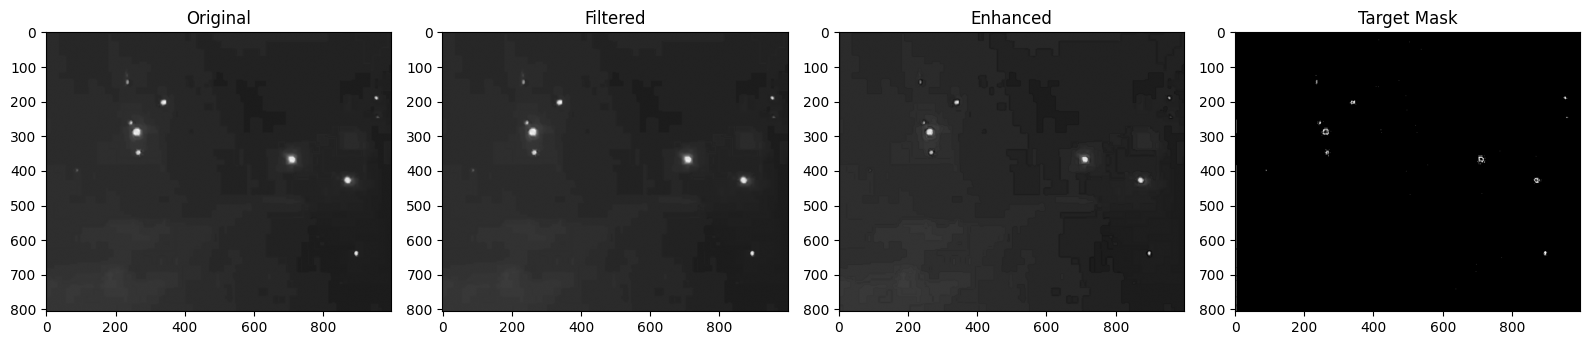

Total targets detected: 10
Target centers: [(894, 639), (872, 426), (869, 429), (709, 370), (265, 350), (261, 291), (245, 265), (339, 205), (950, 192), (235, 146)]
Total targets detected: 10
Target centers: [(894, 639), (872, 426), (869, 429), (709, 370), (265, 350), (261, 291), (245, 265), (339, 205), (950, 192), (235, 146)]


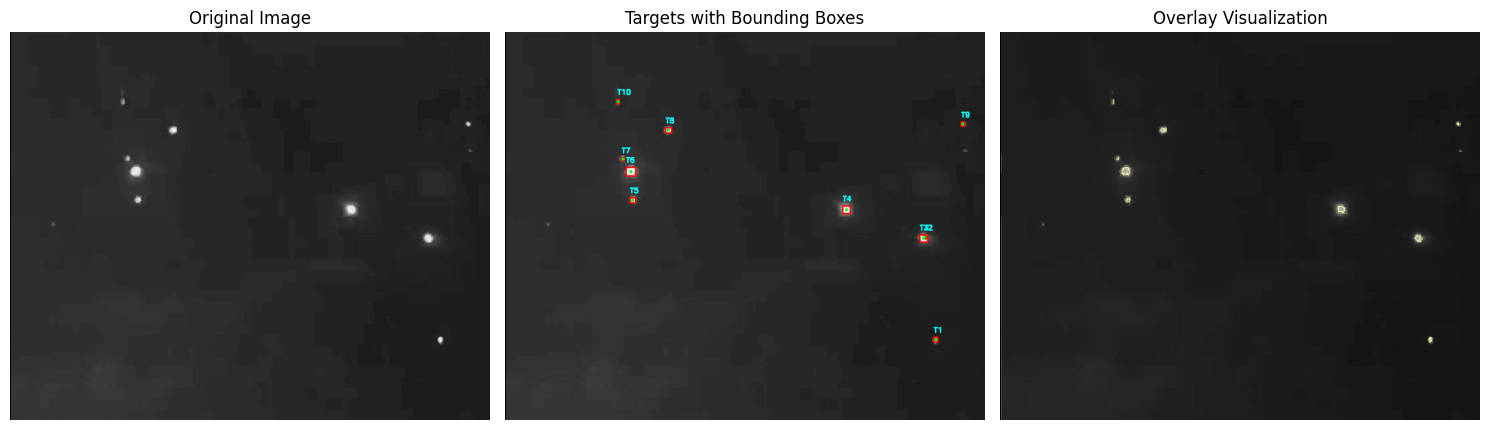

Marked image saved as 'marked_targets.png'


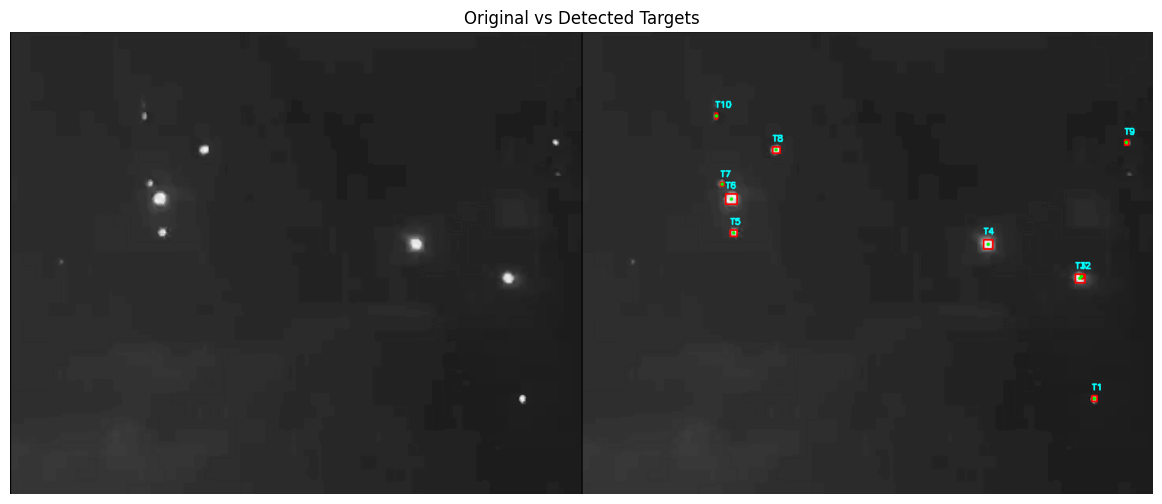

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, gaussian_filter

img = cv2.imread('/content/test image 2.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
M, N = img.shape

print(img)

plt.figure(figsize=(16, 6))
plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')

def compute_point_spread_indicator(I0, Im, In):
    # Avoid log(0) issues
    if I0 <= 0 or Im <= 0 or In <= 0:
        return 0
    numerator = np.log(I0) - np.log(Im)
    denominator = np.log(I0) - np.log(In)
    if denominator == 0:
        return 0
    return numerator / denominator

def point_spread_filter(img):
    padded = np.pad(img, 1, mode='reflect')
    filtered = np.zeros_like(img)

    for i in range(M):
        for j in range(N):
            c = padded[i+1, j+1]
            direct = [padded[i+1, j], padded[i+1, j+2], padded[i, j+1], padded[i+2, j+1]]
            diagonal = [padded[i, j], padded[i, j+2], padded[i+2, j], padded[i+2, j+2]]
            Im = np.mean(direct)
            In = np.mean(diagonal)
            p = compute_point_spread_indicator(c, Im, In)
            if 0.35 <= p <= 0.65:
                filtered[i, j] = c
            else:
                filtered[i, j] = np.median(padded[i:i+3, j:j+3])
    return filtered

filtered_img = point_spread_filter(img)
print(filtered_img)
plt.subplot(1, 4, 2)
plt.title("Filtered")
plt.imshow(filtered_img, cmap='gray')

def point_spread_local_contrast(img):
    padded = np.pad(img, 1, mode='reflect')
    R = np.zeros_like(img)

    for i in range(M):
        for j in range(N):
            I0 = padded[i+1, j+1]
            neighbors = [padded[i+1, j], padded[i+1, j+2], padded[i, j+1], padded[i+2, j+1],
                         padded[i, j], padded[i, j+2], padded[i+2, j], padded[i+2, j+2]]
            direct = [padded[i+1, j], padded[i+1, j+2], padded[i, j+1], padded[i+2, j+1]]
            L = min([I0**2 / (n + 1e-6) for n in neighbors])
            r = (min(direct) / (max(direct) + 1e-6))
            R[i, j] = r * L
    return R

PSLCM = point_spread_local_contrast(filtered_img)

plt.subplot(1, 4, 3)
plt.title("Enhanced")
plt.imshow(PSLCM, cmap='gray')

def high_boost_enhancement(PSLCM):
    MF = cv2.GaussianBlur(PSLCM,(9,9),1)  # Approx 9x9
    B = np.maximum(PSLCM - MF, 1)
    enhanced = PSLCM * B
    return enhanced

enhanced_img = high_boost_enhancement(PSLCM)

def normalize_image(enhanced_img):
    norm = cv2.normalize(enhanced_img, None, 0, 255, cv2.NORM_MINMAX)
    return norm.astype(np.uint8)

enhanced_image=normalize_image(enhanced_img)

print(np.sort(enhanced_image.flatten())[::-1])
print(enhanced_image)

def threshold_image(enhanced_image, method: str = 'static', thresh_val: int = 20):
    if method == 'static':
        thresh = cv2.inRange(enhanced_image, thresh_val, 255)
    elif method == 'adaptive':
        thresh = cv2.adaptiveThreshold(
            enhanced_image, 255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            11, 2
        )
    else:
        raise ValueError("Unknown threshold method. Use 'static' or 'adaptive'.")
    return thresh

threshed_img=threshold_image(enhanced_image)

def adaptive_segmentation(enhanced):
    V = np.sort(enhanced.flatten())[::-1]
    S = np.unique(V)
    len_S = len(S)
    for i in range(min(10, len_S - 2), 1, -1):
        s0, s1, s2 = S[i], S[i + 1], S[i + 2]
        r = (s0 - s1) / (s1 - s2 + 1e-6)
        if r > 0.9:
            T = s0
            break
        elif r < 0.2:
            T = s1
            break
    else:
        T = V[10] if len(V) > 10 else V[-1]
    mask = (enhanced >= T).astype(np.uint8) * 255
    return mask

binary_mask = adaptive_segmentation(enhanced_image)

plt.subplot(1, 4, 4)
plt.title("Target Mask")
plt.imshow(binary_mask, cmap='gray')
plt.tight_layout()
plt.show()

# ===== IMPROVED TARGET MARKING ON ORIGINAL IMAGE =====

def mark_targets_on_original(original_img, binary_mask, method='contours'):
    """
    Mark detected targets on the original image with different visualization options
    """
    # Normalize original image to uint8 if needed
    if original_img.dtype != np.uint8:
        original_display = cv2.normalize(original_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    else:
        original_display = original_img.copy()

    # Convert to BGR for colored markings
    if len(original_display.shape) == 2:
        marked_img = cv2.cvtColor(original_display, cv2.COLOR_GRAY2BGR)
    else:
        marked_img = original_display.copy()

    if method == 'contours':
        # Find contours of detected targets
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes and center points for each target
        target_count = 0
        target_centers = []

        for contour in contours:
            # Filter out very small detections (noise)
            area = cv2.contourArea(contour)
            if area < 3:  # Minimum area threshold
                continue

            target_count += 1

            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)

            # Calculate center
            center_x = x + w // 2
            center_y = y + h // 2
            target_centers.append((center_x, center_y))

            # Draw bounding box in red
            cv2.rectangle(marked_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

            # Draw center point in green
            cv2.circle(marked_img, (center_x, center_y), 3, (0, 255, 0), -1)

            # Add target number label
            cv2.putText(marked_img, f'T{target_count}', (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        print(f"Total targets detected: {target_count}")
        print(f"Target centers: {target_centers}")

    elif method == 'overlay':
        # Create colored overlay
        colored_mask = np.zeros_like(marked_img, dtype=np.uint8)
        colored_mask[binary_mask > 0] = (0, 255, 255)  # Yellow overlay

        # Blend with original image
        marked_img = cv2.addWeighted(marked_img, 0.7, colored_mask, 0.3, 0)



    return marked_img

# Create different visualizations
marked_contours = mark_targets_on_original(img, binary_mask, method='contours')
marked_overlay = mark_targets_on_original(img, binary_mask, method='overlay')

# Create visualizations
marked_contours = mark_targets_on_original(img, binary_mask, method='contours')
marked_overlay = mark_targets_on_original(img, binary_mask, method='overlay')

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(marked_contours, cv2.COLOR_BGR2RGB))
plt.title('Targets with Bounding Boxes')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(marked_overlay, cv2.COLOR_BGR2RGB))
plt.title('Overlay Visualization')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the marked image
cv2.imwrite('marked_targets.png', marked_contours)
print("Marked image saved as 'marked_targets.png'")

# Optional: Create a side-by-side comparison
comparison = np.hstack([
    cv2.cvtColor(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), cv2.COLOR_GRAY2BGR),
    marked_contours
])

plt.figure(figsize=(15, 6))
plt.imshow(cv2.cvtColor(comparison, cv2.COLOR_BGR2RGB))
plt.title('Original vs Detected Targets')
plt.axis('off')
plt.show()

